<a href="https://colab.research.google.com/github/mot1122/NLP_100_knock/blob/main/chap6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

第6章: 機械学習
本章では，Fabio Gasparetti氏が公開しているNews Aggregator Data Setを用い，ニュース記事の見出しを「ビジネス」「科学技術」「エンターテイメント」「健康」のカテゴリに分類するタスク（カテゴリ分類）に取り組む．

50 News Aggregator Data Setをダウンロードし、以下の要領で学習データ（train.txt），検証データ（valid.txt），評価データ（test.txt）を作成せよ．

ダウンロードしたzipファイルを解凍し，readme.txtの説明を読む．
情報源（publisher）が”Reuters”, “Huffington Post”, “Businessweek”, “Contactmusic.com”, “Daily Mail”の事例（記事）のみを抽出する．
抽出された事例をランダムに並び替える．
抽出された事例の80%を学習データ，残りの10%ずつを検証データと評価データに分割し，それぞれtrain.txt，valid.txt，test.txtというファイル名で保存する．ファイルには，１行に１事例を書き出すこととし，カテゴリ名と記事見出しのタブ区切り形式とせよ（このファイルは後に問題70で再利用する）．
学習データと評価データを作成したら，各カテゴリの事例数を確認せよ．

In [1]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip

--2022-01-23 10:27:05--  https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29224203 (28M) [application/x-httpd-php]
Saving to: ‘NewsAggregatorDataset.zip’

NewsAggregatorDatas 100%[===================>]  27.87M  21.8MB/s    in 1.3s    

2022-01-23 10:27:07 (21.8 MB/s) - ‘NewsAggregatorDataset.zip’ saved [29224203/29224203]



In [2]:
!unzip NewsAggregatorDataset.zip

Archive:  NewsAggregatorDataset.zip
  inflating: 2pageSessions.csv       
   creating: __MACOSX/
  inflating: __MACOSX/._2pageSessions.csv  
  inflating: newsCorpora.csv         
  inflating: __MACOSX/._newsCorpora.csv  
  inflating: readme.txt              
  inflating: __MACOSX/._readme.txt   


In [3]:
# 行数の確認
!wc -l ./newsCorpora.csv

422937 ./newsCorpora.csv


In [4]:
!head -5 ./newsCorpora.csv

1	Fed official says weak data caused by weather, should not slow taper	http://www.latimes.com/business/money/la-fi-mo-federal-reserve-plosser-stimulus-economy-20140310,0,1312750.story\?track=rss	Los Angeles Times	b	ddUyU0VZz0BRneMioxUPQVP6sIxvM	www.latimes.com	1394470370698
2	Fed's Charles Plosser sees high bar for change in pace of tapering	http://www.livemint.com/Politics/H2EvwJSK2VE6OF7iK1g3PP/Feds-Charles-Plosser-sees-high-bar-for-change-in-pace-of-ta.html	Livemint	b	ddUyU0VZz0BRneMioxUPQVP6sIxvM	www.livemint.com	1394470371207
3	US open: Stocks fall after Fed official hints at accelerated tapering	http://www.ifamagazine.com/news/us-open-stocks-fall-after-fed-official-hints-at-accelerated-tapering-294436	IFA Magazine	b	ddUyU0VZz0BRneMioxUPQVP6sIxvM	www.ifamagazine.com	1394470371550
4	Fed risks falling 'behind the curve', Charles Plosser says	http://www.ifamagazine.com/news/fed-risks-falling-behind-the-curve-charles-plosser-says-294430	IFA Magazine	b	ddUyU0VZz0BRneMioxUPQVP6sIxvM	www

In [5]:
!sed -e 's/"/'\''/g' ./newsCorpora.csv > ./newsCorpora_re.csv

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split

df=pd.read_csv('./newsCorpora_re.csv',header=None,sep='\t',names=['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP'])

In [7]:
df.head(2)

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
0,1,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,1394470370698
1,2,Fed's Charles Plosser sees high bar for change...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,1394470371207


In [8]:
pd.set_option("display.max_columns",5)
pd.set_option("display.max_rows",5)

In [9]:
df=df.loc[df["PUBLISHER"].isin(["Reuters", "Huffington Post", "Businessweek", "Contactmusic.com", "Daily Mail"]),["TITLE","CATEGORY"]]

In [10]:
train,valid_test=train_test_split(df,test_size=0.2,shuffle=True,random_state=123,stratify=df['CATEGORY'])
valid,test=train_test_split(valid_test,test_size=0.5,shuffle=True,random_state=123,stratify=valid_test['CATEGORY'])

In [11]:
train.to_csv('./train.txt',sep='\t',index=False)
valid.to_csv('./valid.txt',sep='\t',index=False)
test.to_csv('./test.txt',sep='\t',index=False)

In [12]:
print("[train]")
print(train['CATEGORY'].value_counts())
print()
print('[valid]')
print(valid['CATEGORY'].value_counts())
print()
print('[test]')
print(test['CATEGORY'].value_counts())
print()

[train]
b    4501
e    4235
t    1220
m     728
Name: CATEGORY, dtype: int64

[valid]
b    563
e    529
t    153
m     91
Name: CATEGORY, dtype: int64

[test]
b    563
e    530
t    152
m     91
Name: CATEGORY, dtype: int64



51 特徴量抽出

In [13]:
import string
import re

def preprocessing(text):
  table=str.maketrans(string.punctuation," "*len(string.punctuation))
  text=text.translate(table)
  text=text.lower()
  text=re.sub("[0-9]+","0",text)
  return text

In [14]:
df=pd.concat([train,valid,test],axis=0)
df.reset_index(drop=True,inplace=True)
df['TITLE']=df['TITLE'].map(lambda x:preprocessing(x))

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

train_valid=df[:len(train)+len(valid)]
test=df[len(train)+len(valid):]

vec_tfidf=TfidfVectorizer(min_df=10, ngram_range=(1,2))
X_train_valid=vec_tfidf.fit_transform(train_valid["TITLE"])
X_test=vec_tfidf.transform(test["TITLE"])

In [16]:
X_train_valid=pd.DataFrame(X_train_valid.toarray(),columns=vec_tfidf.get_feature_names())
X_test=pd.DataFrame(X_test.toarray(),columns=vec_tfidf.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [17]:
X_train=X_train_valid[:len(train)]
X_valid=X_train_valid[len(train):]

X_train.to_csv('./X_train.txt',sep='\t',index=False)
X_valid.to_csv('./X_valid.txt',sep='\t',index=False)
X_test.to_csv('./X_test.txt',sep='t',index=False)

52 51で構築した学習データを用いて，ロジスティック回帰モデルを学習せよ．

In [18]:
from sklearn.linear_model import LogisticRegression

lg=LogisticRegression(random_state=123,max_iter=10000)
lg.fit(X_train,train['CATEGORY'])

LogisticRegression(max_iter=10000, random_state=123)

53 52で学習したロジスティック回帰モデルを用い，与えられた記事見出しからカテゴリとその予測確率を計算するプログラムを実装せよ．

In [19]:
import numpy as np

def score_lg(lg, X):
  return [np.max(lg.predict_proba(X),axis=1),lg.predict(X)]

In [20]:
train_pred=score_lg(lg,X_train)
test_pred=score_lg(lg,X_test)

In [21]:
print(train_pred)

[array([0.84027948, 0.67904336, 0.55638881, ..., 0.86051   , 0.61359296,
       0.90828249]), array(['b', 't', 'm', ..., 'b', 'm', 'e'], dtype=object)]


54 52で学習したロジスティック回帰モデルの正解率を，学習データおよび評価データ上で計測せよ．

In [22]:
from sklearn.metrics import accuracy_score

train_accuracy = accuracy_score(train['CATEGORY'],train_pred[1])
test_accuracy = accuracy_score(test['CATEGORY'],test_pred[1])

In [23]:
print(f"正解率(trainデータ)：{train_accuracy:.3f}")
print(f"正解率(testデータ)：{test_accuracy:.3f}")

正解率(trainデータ)：0.927
正解率(testデータ)：0.885


55 52で学習したロジスティック回帰モデルの混同行列（confusion matrix）を，学習データおよび評価データ上で作成せよ．

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [25]:
train_cm=confusion_matrix(train["CATEGORY"],train_pred[1])

In [26]:
print(train_cm)

[[4344   93    8   56]
 [  52 4173    2    8]
 [  96  125  494   13]
 [ 192  133    7  888]]


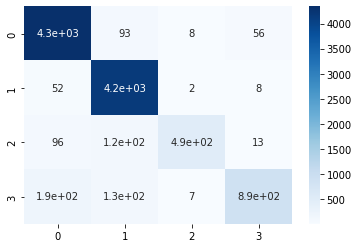

In [27]:
sns.heatmap(train_cm,annot=True,cmap="Blues")
plt.show()

56 52で学習したロジスティック回帰モデルの適合率，再現率，F1スコアを，評価データ上で計測せよ．カテゴリごとに適合率，再現率，F1スコアを求め，カテゴリごとの性能をマイクロ平均（micro-average）とマクロ平均（macro-average）で統合せよ．

In [28]:
from sklearn.metrics import precision_score,recall_score,f1_score

In [29]:
def culculate_scores(y_true,y_pred):
  precision=precision_score(y_true,y_pred,average=None,labels=["b","e","t","m"])
  precision=np.append(precision,precision_score(y_true,y_pred,average="micro"))
  precision=np.append(precision,precision_score(y_true,y_pred,average="macro"))

  recall=recall_score(y_true,y_pred,average=None,labels=["b","e","t","m"])
  recall=np.append(recall,recall_score(y_true,y_pred,average="micro"))
  recall=np.append(recall,recall_score(y_true,y_pred,average="macro"))

  f1=f1_score(y_true,y_pred,average=None,labels=["b","e","t","m"])
  f1=np.append(f1,f1_score(y_true,y_pred,average="micro"))
  f1=np.append(f1,f1_score(y_true,y_pred,average="macro"))

  scores=pd.DataFrame({"precision":precision, "recall":recall, "f1":f1},index=['b', 'e', 't', 'm', 'micro', 'macro'])

  return scores

In [30]:
print(culculate_scores(test['CATEGORY'],test_pred[1]))

       precision    recall        f1
b       0.896435  0.937833  0.916667
e       0.877551  0.973585  0.923077
...          ...       ...       ...
micro   0.885479  0.885479  0.885479
macro   0.886804  0.763804  0.807395

[6 rows x 3 columns]


57 52で学習したロジスティック回帰モデルの中で，重みの高い特徴量トップ10と，重みの低い特徴量トップ10を確認せよ．

In [31]:
print(X_train.columns.values)

['0m' '0million' '0nd' ... 'zac efron' 'zendaya' 'zone']


In [32]:
features=X_train.columns.values
index=range(1,11)
for c,coef in zip(lg.classes_,lg.coef_):
  print(f"カテゴリ：{c}")
  best10=pd.DataFrame(features[np.argsort(coef)[::-1][:10]],columns=["best"],index=index).T
  worst10=pd.DataFrame(features[np.argsort(coef)[:10]],columns=["worst"],index=index).T  
  display(pd.concat([best10,worst10],axis=0))
  print()

カテゴリ：b


,1,2,...,9,10
best,bank,fed,...,yellen,dollar
worst,video,ebola,...,star,microsoft



カテゴリ：e


,1,2,...,9,10
best,kardashian,chris,...,wedding,she
worst,us,update,...,apple,says



カテゴリ：m


,1,2,...,9,10
best,ebola,study,...,could,cigarettes
worst,facebook,gm,...,climate,twitter



カテゴリ：t


,1,2,...,9,10
best,google,facebook,...,comcast,heartbleed
worst,stocks,fed,...,still,shares


58 ロジスティック回帰モデルを学習するとき，正則化パラメータを調整することで，学習時の過学習（overfitting）の度合いを制御できる．異なる正則化パラメータでロジスティック回帰モデルを学習し，学習データ，検証データ，および評価データ上の正解率を求めよ．実験の結果は，正則化パラメータを横軸，正解率を縦軸としたグラフにまとめよ．

In [33]:
from tqdm import tqdm
result=[]
for C in tqdm(np.logspace(-5,4,10,base=10)):
  lg=LogisticRegression(random_state=123,max_iter=10000,C=C)
  lg.fit(X_train,train['CATEGORY'])
  train_pred=score_lg(lg,X_train)
  valid_pred=score_lg(lg,X_valid)
  test_pred=score_lg(lg,X_test)
  train_accuracy=accuracy_score(train['CATEGORY'],train_pred[1])
  valid_accuracy=accuracy_score(valid['CATEGORY'],valid_pred[1])
  test_accuracy=accuracy_score(test['CATEGORY'],test_pred[1])
  result.append([C,train_accuracy,valid_accuracy,test_accuracy])

100%|██████████| 10/10 [11:58<00:00, 71.89s/it] 


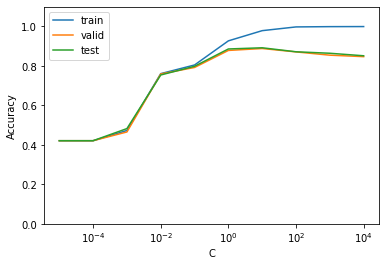

In [34]:
result=np.array(result).T
plt.plot(result[0],result[1],label='train')
plt.plot(result[0],result[2],label='valid')
plt.plot(result[0],result[3],label='test')
plt.ylim(0,1.1)
plt.xlabel('C')
plt.xscale('log')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

59 学習アルゴリズムや学習パラメータを変えながら，カテゴリ分類モデルを学習せよ．検証データ上の正解率が最も高くなる学習アルゴリズム・パラメータを求めよ．また，その学習アルゴリズム・パラメータを用いたときの評価データ上の正解率を求めよ．

In [35]:
!pip install optuna

     |████████████████████████████████| 308 kB 28.8 MB/s 
     |████████████████████████████████| 209 kB 60.0 MB/s 
     |████████████████████████████████| 80 kB 12.5 MB/s 
     |████████████████████████████████| 75 kB 6.3 MB/s 
     |████████████████████████████████| 112 kB 75.8 MB/s 
     |████████████████████████████████| 49 kB 8.2 MB/s 
     |████████████████████████████████| 149 kB 71.9 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=3987f824857113b0cde56d44d7b71de9cae78a3a81af31e028a9890246e2d0c7
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [36]:
import optuna

In [37]:
# 最適化対象を関数で指定
def objective_lg(trial):
  # チューニング対象パラメータのセット
  l1_ratio = trial.suggest_uniform('l1_ratio', 0, 1)
  C = trial.suggest_loguniform('C', 1e-4, 1e4)

  # モデルの学習
  lg = LogisticRegression(random_state=123, 
                          max_iter=10000, 
                          penalty='elasticnet', 
                          solver='saga', 
                          l1_ratio=l1_ratio, 
                          C=C)
  lg.fit(X_train, train['CATEGORY'])

  # 予測値の取得
  valid_pred = score_lg(lg, X_valid)

  # 正解率の算出
  valid_accuracy = accuracy_score(valid['CATEGORY'], valid_pred[1])    

  return valid_accuracy 

In [38]:
# 最適化
study = optuna.create_study(direction='maximize')

[I 2022-01-23 10:40:08,438] A new study created in memory with name: no-name-9164d739-aae1-4b29-8eaa-93ba7cb49560


In [39]:
study.optimize(objective_lg, timeout=10)

[I 2022-01-23 10:40:47,530] Trial 0 finished with value: 0.8884730538922155 and parameters: {'l1_ratio': 0.04275654233849768, 'C': 1.6272753486864038}. Best is trial 0 with value: 0.8884730538922155.


In [40]:
# 結果の表示
print('Best trial:')
trial = study.best_trial
print('  Value: {:.3f}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
  print('    {}: {}'.format(key, value))

Best trial:
  Value: 0.888
  Params: 
    l1_ratio: 0.04275654233849768
    C: 1.6272753486864038


In [41]:
l1_ratio=trial.params["l1_ratio"]
C=trial.params["C"]
lg=LogisticRegression(random_state=123,max_iter=10000, penalty="elasticnet",solver="saga",l1_ratio=l1_ratio,C=C)
lg.fit(X_train,train["CATEGORY"])
train_pred=score_lg(lg,X_train)
valid_pred=score_lg(lg,X_valid)
test_pred=score_lg(lg,X_test)
train_accuracy=accuracy_score(train["CATEGORY"],train_pred[1])
valid_accuracy=accuracy_score(valid["CATEGORY"],valid_pred[1])
test_accuracy=accuracy_score(test["CATEGORY"],test_pred[1])
print(f"train accuracy={train_accuracy}")
print(f"valid accuracy={valid_accuracy}")
print(f"test accuracy={test_accuracy}")

train accuracy=0.9393485585922875
valid accuracy=0.8884730538922155
test accuracy=0.8929640718562875


In [42]:
!pip install xgboost
import xgboost as xgb

In [43]:
params={
    "obfective":"multi:softmax",
    "num_class":4,
    "eval_metric":"mlogloss",
    "colsample_bytree":1.0,
    "colsample_bylevel":0.5,
    "min_chile_weight":1.0,
    "sabsample":0.9,
    "eta":0.1,
    "max_depth":5,
    "gamma":0,
    "alpha":0,
    "lambda":1.0,
    "num_round":200,
    "early_stopping_rounds":10,
    "verbosity":0
    }
category_dict={"b":0,"e":1,"t":2,"m":3}
y_train=train["CATEGORY"].map(lambda x:category_dict[x])
y_valid=valid["CATEGORY"].map(lambda x:category_dict[x])
y_test=test["CATEGORY"].map(lambda x:category_dict[x])
dtrain=xgb.DMatrix(X_train,y_train)
dvalid=xgb.DMatrix(X_valid,y_valid)
dtest=xgb.DMatrix(X_test,y_test)
num_round=params.pop("num_round")
early_stopping_rounds=params.pop("early_stopping_rounds")
watchlist=[[dtrain,"train"],[dvalid,"eval"]]
model=xgb.train(params,dtrain,num_round,evals=watchlist,early_stopping_rounds=early_stopping_rounds)

[0]	train-mlogloss:1.32642	eval-mlogloss:1.32611
Multiple eval metrics have been passed: 'eval-mlogloss' will be used for early stopping.

Will train until eval-mlogloss hasn't improved in 10 rounds.
[1]	train-mlogloss:1.27436	eval-mlogloss:1.2738
[2]	train-mlogloss:1.22922	eval-mlogloss:1.22762
[3]	train-mlogloss:1.19009	eval-mlogloss:1.1898
[4]	train-mlogloss:1.15516	eval-mlogloss:1.15453
[5]	train-mlogloss:1.12434	eval-mlogloss:1.12429
[6]	train-mlogloss:1.09631	eval-mlogloss:1.09627
[7]	train-mlogloss:1.07105	eval-mlogloss:1.07068
[8]	train-mlogloss:1.04736	eval-mlogloss:1.04648
[9]	train-mlogloss:1.02662	eval-mlogloss:1.02609
[10]	train-mlogloss:1.00736	eval-mlogloss:1.00619
[11]	train-mlogloss:0.989489	eval-mlogloss:0.988119
[12]	train-mlogloss:0.973524	eval-mlogloss:0.973355
[13]	train-mlogloss:0.95863	eval-mlogloss:0.957826
[14]	train-mlogloss:0.944839	eval-mlogloss:0.943324
[15]	train-mlogloss:0.931885	eval-mlogloss:0.930973
[16]	train-mlogloss:0.919665	eval-mlogloss:0.919673


In [44]:
train_pred=model.predict(dtrain,ntree_limit=model.best_ntree_limit)
valid_pred=model.predict(dvalid,ntree_limit=model.best_ntree_limit)
test_pred=model.predict(dtest,ntree_limit=model.best_ntree_limit)
train_accuracy=accuracy_score(y_train,train_pred)
valid_accuracy=accuracy_score(y_valid,valid_pred)
test_accuracy=accuracy_score(y_test,test_pred)

In [45]:
print(f"train_accuracy:{train_accuracy}")
print(f"valid_accuracy:{valid_accuracy}")
print(f"test_accuracy:{test_accuracy}")

train_accuracy:0.8653126169973793
valid_accuracy:0.8353293413173652
test_accuracy:0.8345808383233533
